In [1]:
# ref: https://www.hackster.io/rlk3/young-boys-0b1d78
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from IPython.display import clear_output
import tflite_runtime.interpreter as tflite


In [2]:
class PidClass:
    p = 0
    i = 0
    d = 0

    error_last = 0
    error_last2 = 0

    def __init__(self, p, i, d):
        self.p = p
        self.i = i
        self.d = d

    def get(self, error):
        # p
        output = self.p * (error - self.error_last)
        # i
        output += self.i * error
        # d
        output += self.d * (error - 2*self.error_last + self.error_last2)
        self.error_last2 = self.error_last
        self.error_last = error
        return output


class PidClass2:
    p = 0
    i = 0
    d = 0

    error_i = 0
    error_last = 0

    def __init__(self, p, i, d):
        self.p = p
        self.i = i
        self.d = d

    def get(self, error):
        # p
        output = self.p * error
        # i
        self.error_i += error
        output += self.i * self.error_i
        # d
        output += self.d * (error - self.error_last)
        self.error_last = error
        return output


class Speed:

    target_speed = 0
    current_speed = 0
    current_count = 0
    current_output = 0
    data = dict()

    def __init__(self, target_speed, p, i, d):
        self.target_speed = target_speed
        self.pid = PidClass(p, i, d)
        self.data["current_count"] = []
        self.data["current_speed"] = []
        self.data["current_output"] = []
        self.data["time"] = []

    def get_count(self):
        with open('/sys/module/hello/parameters/count', 'r') as filetowrite:
            new_count = filetowrite.readline()
            new_count = new_count[:-1]
            new_count = int(new_count)
            count = new_count - self.current_count
            self.current_count = new_count
            return count

    def get_time(self, i):
        with open('/sys/module/hello/parameters/x' + str(i), 'r') as filetowrite:
            time = filetowrite.readline()
            time = time[:-1]
            time = int(time)
            return time

    def get_speed(self):
        count = self.get_count()
        self.data["current_count"].append(count)
        if count == 0:
            self.data["current_speed"].append(0)
            return 0
        count = min(count, 5)
        time_list = np.zeros(count)
        for i in range(count):
            time_list[i] = (self.get_time(i)+1)
        speed = 1000/np.average(time_list)
        self.data["current_speed"].append(speed)
        return speed

    def init_pwm(self):
        with open('/dev/bone/pwm/1/a/period', 'w') as filetowrite:
            filetowrite.write('20000000')
        with open('/dev/bone/pwm/1/a/duty_cycle', 'w') as filetowrite:
            filetowrite.write('1500000')
        with open('/dev/bone/pwm/1/a/enable', 'w') as filetowrite:
            filetowrite.write('1')

    def set_speed(self, value):
        value = max(0, min(100, value))
        self.current_output = value
        pwd = str(int(value * 4000 + 1500000))
        with open('/dev/bone/pwm/1/a/duty_cycle', 'w') as filetowrite:
            filetowrite.write(pwd)
        return value

    def update(self):
        self.data["time"].append(time.time())
        self.current_speed = self.get_speed()
        speed_error = self.target_speed - self.current_speed
        speed_pid = self.pid.get(speed_error)
        self.current_output += speed_pid
        self.current_output = self.set_speed(self.current_output)
        self.data["current_output"].append(self.current_output)


class Camera:

    height = 240
    width = 320
    model_size = 320
    fps = 10
    red_threshold = 0.5 * height/2 * width
    conf_threshold = 0.5
    iou_threshold = 0.45
    #stop_threshold = 0.2 * height * width
    data = dict()

    def __init__(self):
        self.cam = cv2.VideoCapture(2)
        self.cam.set(cv2.CAP_PROP_FRAME_WIDTH, self.width)
        self.cam.set(cv2.CAP_PROP_FRAME_HEIGHT, self.height)
        self.cam.set(cv2.CAP_PROP_FPS, self.fps)
        self.data["red_mask"] = []
        self.data["k"] = []
        self.data["time"] = []
        self.data["frame"] = []
        self.interpreter = tflite.Interpreter(
            model_path="/home/debian/elec533/best-fp16-3.tflite", num_threads=2)
        self.interpreter.allocate_tensors()
        self.output = self.interpreter.get_output_details()[0]
        self.input = self.interpreter.get_input_details()[0]
        self.data["stop"] = []

    def detect_stop(self, frame):

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (self.model_size, self.model_size))
        frame = frame.astype(np.float32)/255
        input_data = np.expand_dims(frame, axis=0)
        # scale, zero_point = self.input['quantization']
        # input_data = (input_data / scale + zero_point).astype(np.uint8)

        self.interpreter.set_tensor(self.input['index'], input_data)
        self.interpreter.invoke()
        output_data = self.interpreter.get_tensor(self.output['index'])[0]

        # scale, zero_point = self.output['quantization']
        class_id = []
        boxes = []
        confs = []
        for i in range(output_data.shape[0]):
            # confidence = (output_data[i][4] - zero_point) * scale
            confidence = output_data[i][4]
            if confidence > self.conf_threshold:
                # center_x = int((output_data[i][0] - zero_point) * scale * self.width)
                # center_y = int((output_data[i][1] - zero_point) * scale * self.height)
                # width = int((output_data[i][2] - zero_point) * scale * self.width)
                # height = int((output_data[i][3] - zero_point) * scale * self.height)
                center_x = int(output_data[i][0] * self.width)
                center_y = int(output_data[i][1] * self.height)
                width = int(output_data[i][2] * self.width)
                height = int(output_data[i][3] * self.height)
                left = center_x - width / 2
                top = center_y - height / 2
                class_id.append(0)
                confs.append(float(confidence))
                boxes.append([left, top, width, height])
        indices = cv2.dnn.NMSBoxes(
            boxes, confs, self.conf_threshold, self.iou_threshold)
        # self.display_box(boxes, confs, indices)
        for index in indices:
            i = index[0]
            box = boxes[i]
            box_size = box[2]*box[3]
            #if box_size > self.stop_threshold:
            return True
        return False

    def detect_red(self, hsv):
        '''
        detect_red color with a given threshold. <:
        '''
        lower_red = np.array([140, 20, 40], dtype="uint8")
        upper_red = np.array([200, 255, 255], dtype="uint8")
        mask = cv2.inRange(hsv, lower_red, upper_red)
        # cv2.imshow("red",mask)
        count = mask.sum()/255
        self.data["red_mask"].append(count)
        return (count > self.red_threshold)

    def detect_blue(self, hsv):
        '''
        detect_red color with a given threshold. <:
        '''
        lower_blue = np.array([70, 90, 0], dtype="uint8")
        upper_blue = np.array([150, 255, 255], dtype="uint8")
        mask = cv2.inRange(hsv, lower_blue, upper_blue)
        # cv2.imshow("blue",mask)
        return mask

    def display_box(self, boxes, confs, indices, line_color=(0, 255, 0), line_width=1):
        # this just displays the boundary lines we previously found on the image
        line_image = np.zeros([self.height, self.width, 3], np.uint8)

        for index in indices:
            i = index[0]
            left = int(boxes[i][0])
            top = int(boxes[i][1])
            width = int(boxes[i][2])
            height = int(boxes[i][3])
            # line displayed here
            cv2.rectangle(line_image, (left, top), (left+width, top+height), line_color, line_width)
            cv2.putText(line_image, str(confs[i]), (left, top+height), cv2.FONT_HERSHEY_SIMPLEX, 1, line_color, line_width)
        cv2.imshow("stop", line_image)

    def display_lines(self, lines, line_color=(0, 255, 0), line_width=1):
        # this just displays the boundary lines we previously found on the image
        line_image = np.zeros([self.height, self.width, 3], np.uint8)

        for line in lines:
            for x1, y1, x2, y2 in line:
                # line displayed here
                cv2.line(line_image, (x1, y1), (x2, y2),
                         line_color, line_width)
        cv2.imshow("lines", line_image)

    def detect_lines(self, mask):
        edges = cv2.Canny(mask, 50, 100)
        # cv2.imshow("edges",edges)
        rho = 1
        theta = np.pi / 180
        min_threshold = 40
        line_segments = cv2.HoughLinesP(edges, rho, theta, min_threshold,
                                        np.array([]), minLineLength=20, maxLineGap=20)
        if line_segments is None:
            return 0
        # self.display_lines(line_segments)
        left = []
        right = []
        for line in line_segments:
            theta = math.atan((line[0][3]-line[0][1])/(line[0][2]-line[0][0]+0.1))
            if theta > 0.1:
                right.append(theta)
            elif theta < -0.1:
                left.append(theta)
        left_k = np.average(left) if left else 0
        right_k = np.average(right) if right else 0
        return (left_k + right_k)

    def update(self):
        _, frame = self.cam.read()
        _, jpg = cv2.imencode(".jpg", frame)
        self.data["frame"].append(jpg)
        # cv2.imshow("frame",frame)
        self.data["time"].append(time.time())
        hsv = cv2.cvtColor(frame[int(self.height/2):, :, :], cv2.COLOR_BGR2HSV)
        red = self.detect_red(hsv)
        blue_mask = self.detect_blue(hsv)
        k = self.detect_lines(blue_mask)
        stop = self.detect_stop(frame)
        return [red, stop, k]

    def close(self):
        self.cam.release()
        for i,jpg in enumerate(self.data["frame"]):
            with open(str(i)+'.jpg', 'wb') as filetowrite:
                filetowrite.write(jpg.tobytes())



class Direction:

    target_direction = 0
    current_direction = 0
    current_output = 0
    data = dict()

    def __init__(self, p, i, d):
        self.pid = PidClass2(p, i, d)
        self.data["current_direction"] = []
        self.data["current_output"] = []
        self.data["red"] = []
        self.data["time"] = []
        self.cam = Camera()

    def init_pwm(self):
        with open('/dev/bone/pwm/1/b/period', 'w') as filetowrite:
            filetowrite.write('20000000')
        with open('/dev/bone/pwm/1/b/duty_cycle', 'w') as filetowrite:
            filetowrite.write('1500000')
        with open('/dev/bone/pwm/1/b/enable', 'w') as filetowrite:
            filetowrite.write('1')

    def set_direction(self, value):
        value = max(-100, min(100, value))
        pwd = str(int(value * 3000 + 1500000))
        with open('/dev/bone/pwm/1/b/duty_cycle', 'w') as filetowrite:
            filetowrite.write(pwd)
        return value

    def update(self):
        red, stop, k = self.cam.update()
        self.data["time"].append(time.time())
        self.data["current_direction"].append(k)
        self.current_output = self.pid.get(k)
        self.current_output = self.set_direction(self.current_output)
        self.data["current_output"].append(self.current_output)
        return red, stop

    def close(self):
        self.cam.close()


In [5]:
direction.close()


In [3]:
speed = Speed(200, 0.05, 0.01, 0.01)
speed.init_pwm()
direction = Direction(60, 0, 0)
direction.init_pwm()


[ WARN:0] global ../modules/videoio/src/cap_gstreamer.cpp (961) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


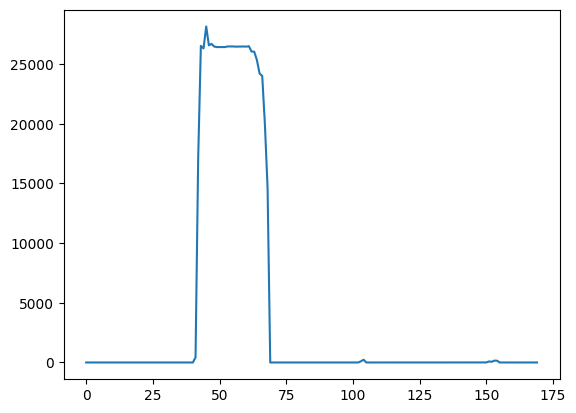

In [5]:
plt.plot(direction.cam.data["red_mask"])

In [42]:
direction.update()

(False, False)

In [4]:
stop_count = 0
red_cooldown = 30
red_count = 0
sign_count = 0
run_loop = 300
for _ in range(run_loop):
    if stop_count:
        stop_count -= 1
        speed.set_speed(0)
    else:
        speed.update()
    red, stop = direction.update()
    if red_cooldown > 0:
         red_cooldown -= 1
    elif red and red_count == 0:
        stop_count = 10
        red_cooldown = 30
        red_count = 1
    elif red and red_count == 1:
        speed.set_speed(0)
        break
    if red_cooldown == 0 and stop and sign_count == 0:
        stop_count = 10
        sign_count = 1

    # clear_output(wait=True)
    #print(f'Speed: {speed.current_speed}, {speed.current_output}')
speed.set_speed(0)
direction.set_direction(0)


0

In [7]:
direction.cam.red_threshold

15360.0

/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


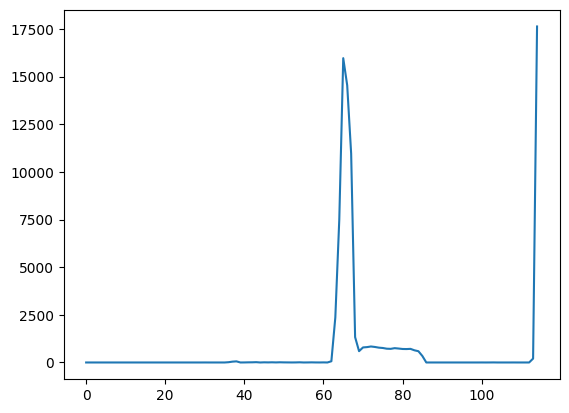

In [6]:
plt.plot(direction.cam.data["red_mask"])

In [12]:
direction.update()

(False, False)

In [14]:
# # init PWM
# # P9_14 - Speed/ESC
# with open('/dev/bone/pwm/1/a/period', 'w') as filetowrite:
#     filetowrite.write('20000000')
# with open('/dev/bone/pwm/1/a/duty_cycle', 'w') as filetowrite:
#     filetowrite.write('1550000')
# with open('/dev/bone/pwm/1/a/enable', 'w') as filetowrite:
#     filetowrite.write('1')
# # P9_16 - Steering
# with open('/dev/bone/pwm/1/b/period', 'w') as filetowrite:
#     filetowrite.write('20000000')
# with open('/dev/bone/pwm/1/b/duty_cycle', 'w') as filetowrite:
#     filetowrite.write('1500000')
# with open('/dev/bone/pwm/1/b/enable', 'w') as filetowrite:
#     filetowrite.write('1')


In [11]:
# with open('/dev/bone/pwm/1/b/duty_cycle', 'w') as filetowrite:
#     filetowrite.write('1500000')


In [14]:
cam = cv2.VideoCapture(2)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)
cam.set(cv2.CAP_PROP_FPS, 10)
# cam.release()


[ WARN:0] global ../modules/videoio/src/cap_gstreamer.cpp (961) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


False

In [37]:
cam.release()

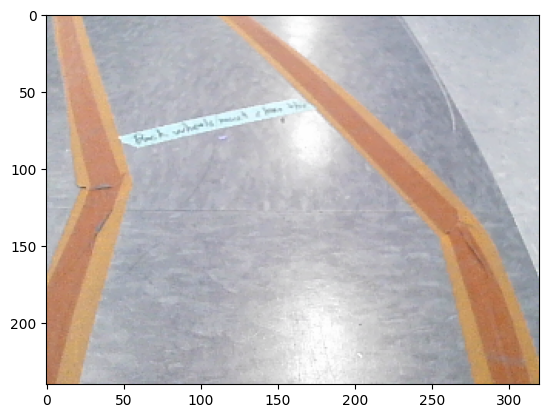

In [17]:
_,frame = cam.read()
plt.imshow(frame)

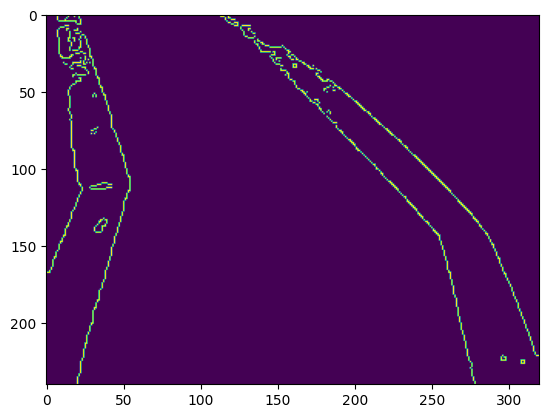

In [32]:
hsv = cv2.cvtColor(frame[], cv2.COLOR_BGR2HSV)
lower_blue = np.array([70, 90, 0], dtype="uint8")
upper_blue = np.array([150, 255, 255], dtype="uint8")
mask = cv2.inRange(hsv, lower_blue, upper_blue)
edges = cv2.Canny(mask, 50, 100)
plt.imshow(edges)

In [36]:
rho = 1
theta = np.pi / 180
min_threshold = 40
line_segments = cv2.HoughLinesP(edges, rho, theta, min_threshold,
                                np.array([]), minLineLength=20, maxLineGap=20)
for line in line_segments:
    theta = math.atan((line[0][3]-line[0][1])/(line[0][2]-line[0][0]+0.1))
    print(line)
    print(theta/3.14*180)

[[121   3 248 135]]
46.10680087884452
[[201  56 263 116]]
44.036990928693946
[[ 22 226  54 112]]
-74.3115707388303
[[257 150 278 239]]
76.70152057974822
[[ 21   0  54 110]]
73.2901364015213
[[190  47 243  95]]
42.13351626237534
[[286 142 310 198]]
66.74886663440535
[[  2 167  23 114]]
-68.32648389622783
[[ 16  78  21 118]]
82.77595543473801


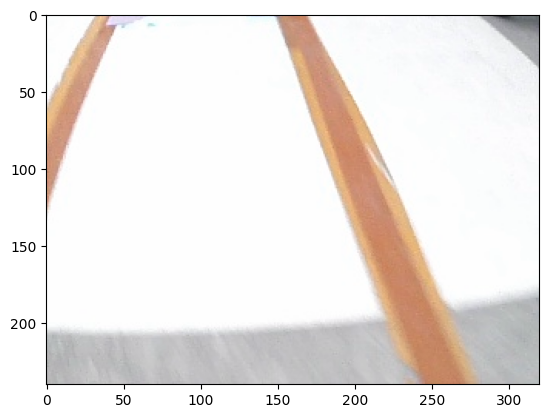

In [4]:
frame = cv2.imread("35.jpg")
plt.imshow(frame)

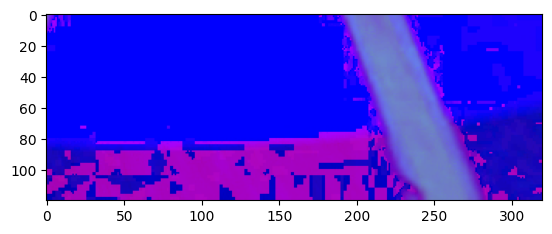

In [5]:
hsv = cv2.cvtColor(frame[int(240/2):, :, :], cv2.COLOR_BGR2HSV)
plt.imshow(hsv)

In [11]:
hsv[20,20]

array([173,  26, 244], dtype=uint8)

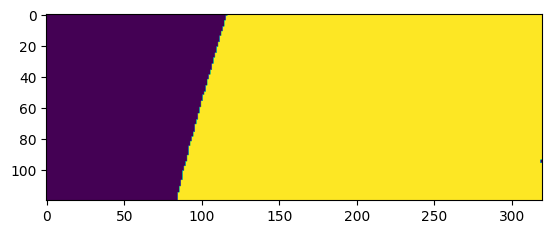

In [16]:
lower_red = np.array([140, 20, 40], dtype="uint8")
upper_red = np.array([200, 255, 255], dtype="uint8")
mask = cv2.inRange(hsv, lower_red, upper_red)
plt.imshow(mask)

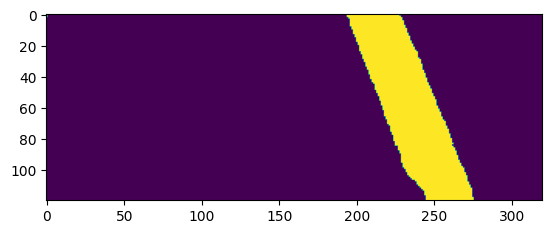

In [6]:
lower_blue = np.array([70, 90, 0], dtype="uint8")
upper_blue = np.array([150, 255, 255], dtype="uint8")
mask = cv2.inRange(hsv, lower_blue, upper_blue)
plt.imshow(mask)

In [21]:
!zip jpg.zip *

  adding: 0.jpg (deflated 1%)
  adding: 100.jpg (deflated 1%)
  adding: 101.jpg (deflated 1%)
  adding: 102.jpg (deflated 1%)
  adding: 103.jpg (deflated 1%)
  adding: 104.jpg (deflated 1%)
  adding: 105.jpg (deflated 1%)
  adding: 106.jpg (deflated 1%)
  adding: 107.jpg (deflated 1%)
  adding: 108.jpg (deflated 1%)
  adding: 109.jpg (deflated 1%)
  adding: 10.jpg (deflated 1%)
  adding: 110.jpg (deflated 1%)
  adding: 111.jpg (deflated 1%)
  adding: 112.jpg (deflated 1%)
  adding: 113.jpg (deflated 1%)
  adding: 114.jpg (deflated 1%)
  adding: 115.jpg (deflated 1%)
  adding: 116.jpg (deflated 1%)
  adding: 117.jpg (deflated 1%)
  adding: 118.jpg (deflated 1%)
  adding: 119.jpg (deflated 1%)
  adding: 11.jpg (deflated 1%)
  adding: 120.jpg (deflated 1%)
  adding: 121.jpg (deflated 1%)
  adding: 122.jpg (deflated 1%)
  adding: 123.jpg (deflated 1%)
  adding: 124.jpg (deflated 1%)
  adding: 125.jpg (deflated 1%)
  adding: 126.jpg (deflated 1%)
  adding: 127.jpg (deflated 1%)
  adding: 12

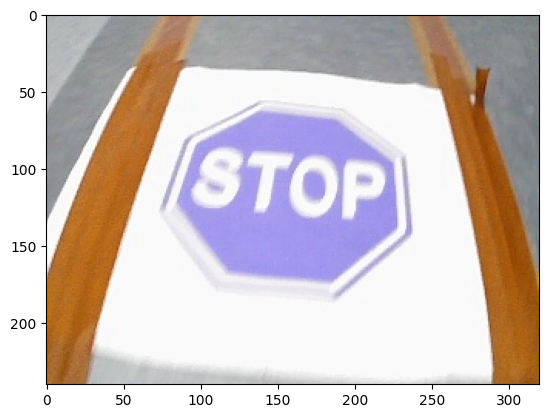

In [18]:
frame = cv2.imread("40.jpg")
plt.imshow(frame)

In [19]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = cv2.resize(frame, (320,320))
frame = frame.astype(np.float32)/255
input_data = np.expand_dims(frame, axis=0)
# scale, zero_point = self.input['quantization']
# input_data = (input_data / scale + zero_point).astype(np.uint8)
interpreter = tflite.Interpreter(
    model_path="/home/debian/elec533/best-fp16-2.tflite", num_threads=2)
interpreter.allocate_tensors()
output = interpreter.get_output_details()[0]
input = interpreter.get_input_details()[0]
        
interpreter.set_tensor(input['index'], input_data)
interpreter.invoke()


In [20]:
output_data = interpreter.get_tensor(output['index'])[0]

# scale, zero_point = self.output['quantization']
class_id = []
boxes = []
confs = []
for i in range(output_data.shape[0]):
    # confidence = (output_data[i][4] - zero_point) * scale
    confidence = output_data[i][4]
    if confidence > 0.1:
        print (output_data[i])
        # center_x = int((output_data[i][0] - zero_point) * scale * self.width)
        # center_y = int((output_data[i][1] - zero_point) * scale * self.height)
        # width = int((output_data[i][2] - zero_point) * scale * self.width)
        # height = int((output_data[i][3] - zero_point) * scale * self.height)
        center_x = int(output_data[i][0] * self.width)
        center_y = int(output_data[i][1] * self.height)
        width = int(output_data[i][2] * self.width)
        height = int(output_data[i][3] * self.height)
        left = center_x - width / 2
        top = center_y - height / 2
        class_id.append(0)
        confs.append(float(confidence))
        boxes.append([left, top, width, height])
indices = cv2.dnn.NMSBoxes(
    boxes, confs, 0.2, 0.45)
# self.display_box(boxes, confs, indices)
for index in indices:
    i = index[0]
    box = boxes[i]
    print(box)

[0.50010544 0.47047228 0.46471915 0.5860121  0.17192386 0.9999717 ]


NameError: name 'self' is not defined

In [21]:
!zip jpg.zip *

updating: 0.jpg (deflated 1%)
updating: 100.jpg (deflated 1%)
updating: 101.jpg (deflated 1%)
updating: 102.jpg (deflated 1%)
updating: 103.jpg (deflated 1%)
updating: 104.jpg (deflated 1%)
updating: 105.jpg (deflated 1%)
updating: 106.jpg (deflated 1%)
updating: 107.jpg (deflated 1%)
updating: 108.jpg (deflated 1%)
updating: 109.jpg (deflated 1%)
updating: 10.jpg (deflated 1%)
updating: 110.jpg (deflated 1%)
updating: 111.jpg (deflated 1%)
updating: 112.jpg (deflated 1%)
updating: 113.jpg (deflated 1%)
updating: 114.jpg (deflated 1%)
updating: 115.jpg (deflated 1%)
updating: 116.jpg (deflated 1%)
updating: 117.jpg (deflated 1%)
updating: 118.jpg (deflated 1%)
updating: 119.jpg (deflated 1%)
updating: 11.jpg (deflated 1%)
updating: 120.jpg (deflated 1%)
updating: 121.jpg (deflated 1%)
updating: 122.jpg (deflated 1%)
updating: 123.jpg (deflated 1%)
updating: 124.jpg (deflated 1%)
updating: 125.jpg (deflated 1%)
updating: 126.jpg (deflated 1%)
updating: 127.jpg (deflated 1%)
updating: 12

In [5]:
	
import pickle

In [7]:
direction

In [9]:
with open("speed.pickle", "wb") as outfile:
 # "wb" argument opens the file in binary mode
 pickle.dump(speed.data, outfile)
with open("camera.pickle", "wb") as outfile:
 # "wb" argument opens the file in binary mode
 pickle.dump(direction.cam.data, outfile)
with open("direction.pickle", "wb") as outfile:
 # "wb" argument opens the file in binary mode
 pickle.dump(direction.data, outfile)